In [117]:
!pip install -q efficientnet

In [118]:
import os
import collections
from datetime import datetime, timedelta
from functools import partial
import math, re, os
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#from kaggle_datasets import KaggleDatasets
from torchvision import datasets, transforms ,utils,models
import efficientnet.tfkeras as efn

from tensorflow.keras.applications import ResNet50V2,ResNet101V2,ResNet152V2,DenseNet201
import cv2
import torch.nn.functional as F
import torch.nn as nn
import os
import shutil
import torch
from torchvision import transforms
from PIL import Image
import pathlib
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.13.0


In [119]:
!ls

In [120]:
# Create strategy from tpu
istpu=False
if istpu:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [121]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
IMAGE_SIZE = [512, 512]
EPOCHS = 20


In [122]:
test = pd.read_csv('../input/test_ApKoW4T.csv')
sample = pd.read_csv('../input/sample_submission_ns2btKE.csv')
train = pd.read_csv('../input/train/train.csv')

In [123]:
convertlabeldict = {1: 'Cargo', 
2:'Military', 
3:'Carrier', 
4:'Cruise', 
5:'Tankers'}
train['category_label'] = train['category'].map(convertlabeldict)

In [124]:
train.head()

,image,category,category_label
0,2823080.jpg,1,Cargo
1,2870024.jpg,1,Cargo
2,2662125.jpg,2,Military
3,2900420.jpg,3,Carrier
4,2804883.jpg,2,Military


In [125]:
train, holdout = train_test_split(train, test_size=0.2, random_state=0, 
                               stratify=train['category'])

In [126]:
train = train.reset_index(drop=True)
train.head()

,image,category,category_label
0,2827293.jpg,1,Cargo
1,2324207.jpg,4,Cruise
2,2816925.jpg,5,Tankers
3,2903004.jpg,3,Carrier
4,2884341.jpg,1,Cargo


In [127]:
holdout = holdout.reset_index(drop=True)
holdout.head()

,image,category,category_label
0,2835355.jpg,5,Tankers
1,2491051.jpg,4,Cruise
2,2862151.jpg,5,Tankers
3,2888474.jpg,1,Cargo
4,697630.jpg,2,Military


In [128]:
test = test.reset_index(drop=True)
test.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [129]:
train['category'].value_counts()

category
1    1696
5     973
2     933
3     733
4     666
Name: count, dtype: int64

In [130]:
holdout['category'].value_counts()

category
1    424
5    244
2    234
3    183
4    166
Name: count, dtype: int64

In [131]:
def copy_files_local(df,basedir,destinationfolder):
    for i,row in df.iterrows():
        currentfileloc = basedir + row['image']
        if not os.path.exists(destinationfolder):
            os.makedirs(destinationfolder)
        shutil.copy(currentfileloc, destinationfolder)

In [132]:
copy_files_local(train,'../input/train/images/','../train/')
copy_files_local(holdout,'../input/train/images/','../holdout/')
copy_files_local(test,'../input/train/images/','../test/')

In [133]:
!ls ../train/ | wc -l
!ls ../holdout/ | wc -l
!ls ../test/ | wc -l


12406
1251
2680


In [134]:
def get_filenames(df,category,image_num):
    return random.sample(df[df.category==category]['image'].tolist(),image_num)

def random_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    rand = random.uniform(0.6, 1.0)
    hsv[:, :, 2] = rand*hsv[:, :, 2]
    rand = random.uniform(1.0, 1.5)
    hsv[:, :, 1] = rand*hsv[:, :, 1]
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return new_img


def zoom(image,rows,cols):
    zoom_pix = random.randint(5, 10)
    zoom_factor = 1 + (2*zoom_pix)/rows
    image = cv2.resize(image, None, fx=zoom_factor,
                       fy=zoom_factor, interpolation=cv2.INTER_LINEAR)
    top_crop = (image.shape[0] - rows)//2
    left_crop = (image.shape[1] - cols)//2
    image = image[top_crop: top_crop+rows,
                  left_crop: left_crop+cols]
    return image

In [135]:
import random

def createaugimagesv2(df,category,image_num,dirname):
    filename = get_filenames(df,category,image_num)
    for images in filename:
        if images[-8:]!='_enh.jpg' and images[-9:]!='_enh1.jpg':
            imagepath = dirname + images
            image = cv2.imread(imagepath)
            rows,cols,channel = image.shape
            image = np.fliplr(image)

            op1 = random.randint(0, 1)
            op2 = random.randint(0, 1)
            op3 = random.randint(0, 1)
            if op1:
                image = random_brightness(image)
            if op2:
                image = zoom(image,rows,cols)
            newimagepath = dirname + images.split('.')[0]+'_'+str(category) + '_enh.jpg'
            try:
                image = cv2.resize(image, (224, 224))
                cv2.imwrite(newimagepath, image)
            except:
                print("file {0} is not converted".format(images))

In [136]:
import random
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

def createaugimages(df,category,image_num,dirname):
    filename = get_filenames(df,category,image_num)
    for images in filename:
        if images[-9:]!='_enh1.jpg':
            imagepath = dirname + images
            pil_im = Image.open(imagepath, 'r').convert('RGB')
            op1 = random.randint(0, 1)
            if op1 ==1:
                changeimg = transforms.Compose([ 
                                        transforms.RandomRotation(5),
                                        transforms.Resize(224),
                                        transforms.ToTensor()
                                       ])
            else:
                changeimg = transforms.Compose([ 
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomRotation(10),
                            transforms.Resize(224),
                            transforms.ToTensor()
                           ])

            img = changeimg(pil_im)
            newimagepath = dirname + images.split('.')[0]+'_'+str(category) + '_enh1.jpg'
            utils.save_image(img,newimagepath)   

In [137]:
def resizeall(dirname):
    filename = os.listdir(dirname)
    non3channel = []
    for images in filename:
        imagepath = dirname + images
        image = cv2.imread(imagepath)
        if image.shape[2] !=3:
            non3channel.append(images)
    return non3channel

In [138]:
convertlabeldict = {1: 'Cargo', 
2:'Military', 
3:'Carrier', 
4:'Cruise', 
5:'Tankers'}

In [139]:
a = 1908 - 1095
b = 1908 - 1050
c = 1908 - 824
d = 1908 - 749

In [141]:
createaugimagesv2(train,5,1696 - 1095,'../train/')
createaugimagesv2(train,2,1696 - 1050,'../train/')


In [142]:
createaugimagesv2(train,3,733,'../train/')
createaugimagesv2(train,4,666,'../train/')

In [143]:
createaugimages(train,1,500,'../train/')
createaugimages(train,5,500,'../train/')
createaugimages(train,2,500,'../train/')
createaugimages(train,3,733,'../train/')
createaugimages(train,4,666,'../train/')

In [144]:
createaugimagesv2(train,3,288,'../train/')
createaugimagesv2(train,4,400,'../train/')

In [145]:
train.shape

(5001, 3)

In [146]:
data_dir = '../train/'
data_dir = pathlib.Path(data_dir)
enh_files = list(data_dir.glob('*_enh.jpg'))
enh_files1 = list(data_dir.glob('*_enh1.jpg'))
allfiles = enh_files+enh_files1

In [147]:
len(allfiles),len(set(allfiles))

(7745, 7745)

In [148]:
train = train.reset_index(drop=False)
train.head()

,index,image,category,category_label
0,0,2827293.jpg,1,Cargo
1,1,2324207.jpg,4,Cruise
2,2,2816925.jpg,5,Tankers
3,3,2903004.jpg,3,Carrier
4,4,2884341.jpg,1,Cargo


In [149]:
holdout = holdout.reset_index(drop=False)
holdout.head()

,index,image,category,category_label
0,0,2835355.jpg,5,Tankers
1,1,2491051.jpg,4,Cruise
2,2,2862151.jpg,5,Tankers
3,3,2888474.jpg,1,Cargo
4,4,697630.jpg,2,Military


In [150]:
test = test.reset_index(drop=False)
test.head()

,index,image
0,0,1007700.jpg
1,1,1011369.jpg
2,2,1051155.jpg
3,3,1062001.jpg
4,4,1069397.jpg


In [151]:
!pip install --upgrade pandas

In [152]:
import pandas as pd

enh_data = []

i = max(train['index'])

for file in allfiles:
    st = str(file)
    cat = st.split('_')[1]
    st = st.split('/')[-1]
    i = i + 1
    
    enh_data.append({
        'index': int(i),
        'image': st,
        'category': int(cat),
        'category_label': convertlabeldict[int(cat)]
    })

enh_df2 = pd.DataFrame(enh_data)


In [153]:
enh_df2['index']=enh_df2['index'].apply(int)
train = pd.concat([train,enh_df]).reset_index(drop=True)
train.head()

,index,image,category,category_label
0,0,2827293.jpg,1,Cargo
1,1,2324207.jpg,4,Cruise
2,2,2816925.jpg,5,Tankers
3,3,2903004.jpg,3,Carrier
4,4,2884341.jpg,1,Cargo


In [154]:
def null_finder(df):
    for col in df.columns.tolist():
        print("For column {0} : NULLS are {1}".format(col,sum(df[col].isnull())))

In [155]:
null_finder(train)

For column index : NULLS are 0
For column image : NULLS are 0
For column category : NULLS are 0
For column category_label : NULLS are 0


In [156]:
null_finder(holdout)

For column index : NULLS are 0
For column image : NULLS are 0
For column category : NULLS are 0
For column category_label : NULLS are 0


In [157]:
null_finder(test)

For column index : NULLS are 0
For column image : NULLS are 0


In [158]:

!ls ../train/ | wc -l
!ls ../holdout/ | wc -l
!ls ../test/ | wc -l


12746
1251
2680


../train/2862082_5_enh.jpg


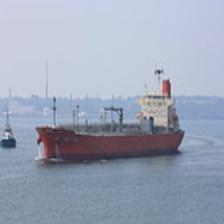

../train/2847709_5_enh.jpg


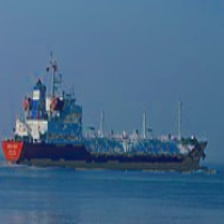

../train/2807234_4_enh.jpg


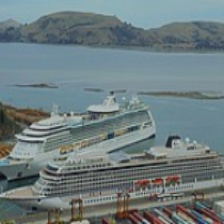

In [159]:
data_dir = '../train/'
data_dir = pathlib.Path(data_dir)
roses = list(data_dir.glob('*_enh.jpg'))
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
for image_path in roses[:3]:
    print(image_path)
    display.display(Image.open(str(image_path)))

In [160]:
BATCH_SIZE = 64
img_size = 224
train_image_count = 10546
hold_image_count = 1251
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)
STEPS_PER_EPOCH_HOLD = np.ceil(hold_image_count/BATCH_SIZE)
STEPS_PER_EPOCH,STEPS_PER_EPOCH_HOLD

(165.0, 20.0)

In [161]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    #img = tf.cast(image, tf.float32) / 255.0 
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [img_size, img_size])

def get_images_label(image,label):
    img = tf.io.read_file(image)
    img = decode_img(img)
    label = tf.cast(label, tf.int32)
    return img,label

def convert_cat(image,label):
    label = tf.convert_to_tensor(tf.keras.utils.to_categorical(label, num_classes=5, dtype='float32'))
    return image,label

def get_images_id(image,ids):
    img = tf.io.read_file(image)
    img = decode_img(img)
    ids = tf.cast(ids, tf.int32)
    return img,ids

def data_augment(image, label, seed=2020):
    
    image = tf.image.random_flip_left_right(image, seed=seed)
#    
    return image, label 

def data_reshape(image,label,seed=2020):
#    
    image = tf.image.random_crop(image, [img_size, img_size], seed=seed)
    return image,label
    

def get_training_dataset(dataset):
    dataset = dataset.map(get_images_label, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() 
    dataset = dataset.shuffle(BATCH_SIZE * 50)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(get_images_label, num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.batch(BATCH_SIZE)
    
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(dataset):
    dataset = dataset.map(get_images_id, num_parallel_calls=AUTOTUNE)
    #dataset = dataset.map(data_reshape, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [162]:
#BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE
CLASSES =[1,2,3,4,5]

dataset_train = tf.data.Dataset.from_tensor_slices(('../train/'+train['image'].values,np.array(pd.get_dummies(train['category'].values))))
dataset_holdout = tf.data.Dataset.from_tensor_slices(('../holdout/'+holdout['image'].values,np.array(pd.get_dummies(holdout['category'].values))))
dataset_test = tf.data.Dataset.from_tensor_slices(('../test/'+test['image'].values,test['index'].values))

In [163]:
final_ds_train = get_training_dataset(dataset_train)
final_ds_holdout = get_training_dataset(dataset_holdout)
final_ds_test = get_test_dataset(dataset_test)

In [164]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        value = label_batch.numpy().tolist()
        value = value[n].index(1) + 1
        plt.title(convertlabeldict[value])
        plt.axis('off')

In [165]:
image_batch, label_batch = next(iter(final_ds_train))

In [167]:
for image,caregory in final_ds_holdout.take(5):
    print(image.shape,caregory.shape)

(64, 224, 224, 3) (64, 5)
(64, 224, 224, 3) (64, 5)
(64, 224, 224, 3) (64, 5)
(64, 224, 224, 3) (64, 5)
(64, 224, 224, 3) (64, 5)


In [168]:
convertlabeldict

{1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tankers'}

In [169]:
def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [170]:
#with strategy.scope():
features_model = DenseNet201(
        input_shape=(img_size, img_size, 3),
        weights='imagenet',
       include_top=False
    

model = tf.keras.Sequential([
    features_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    #optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    optimizer=tf.keras.optimizers.Adam(lr=0.00001),
    loss = 'categorical_crossentropy',
    #loss = macro_f1,
    metrics=['categorical_accuracy']
)
model.summary()

74836368/74836368 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               245888    
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 18568517 (70.83 MB)
Trainable params: 18339461 (69.96 MB)
Non-trainable params: 229056 (894.75 KB)
_________________________________________________________________


In [171]:
gpu_name = tf.test.gpu_device_name()
gpu_name

'/device:GPU:0'

In [172]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history = model.fit(
    final_ds_train, 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=15, 
    validation_data=final_ds_holdout,
    validation_steps=STEPS_PER_EPOCH_HOLD,
    #validation_data=dataset_holdout
    callbacks=[lr_schedule]
)

Epoch 1/15
165/165 [==============================] - 218s 577ms/step - loss: 1.5805 - categorical_accuracy: 0.3799 - val_loss: 1.5845 - val_categorical_accuracy: 0.3508 - lr: 0.0100
Epoch 2/15
165/165 [==============================] - 92s 559ms/step - loss: 1.2362 - categorical_accuracy: 0.4496 - val_loss: 2.8963 - val_categorical_accuracy: 0.4469 - lr: 0.0089
Epoch 3/15
165/165 [==============================] - 93s 563ms/step - loss: 1.0500 - categorical_accuracy: 0.5471 - val_loss: 2.2664 - val_categorical_accuracy: 0.3547 - lr: 0.0079
Epoch 4/15
165/165 [==============================] - 93s 562ms/step - loss: 0.9229 - categorical_accuracy: 0.5946 - val_loss: 1.4117 - val_categorical_accuracy: 0.4391 - lr: 0.0071
Epoch 5/15
165/165 [==============================] - 92s 558ms/step - loss: 0.8178 - categorical_accuracy: 0.6379 - val_loss: 1.5607 - val_categorical_accuracy: 0.4445 - lr: 0.0063
Epoch 6/15
165/165 [==============================] - 93s 564ms/step - loss: 0.6191 - cat

In [186]:
def display_training_curves(training, validation, title, subplot):
    
    plt.subplots(figsize=(6,6))
    plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

/tmp/ipykernel_42/225810534.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


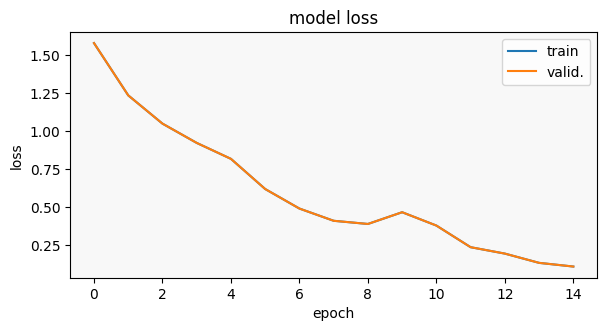

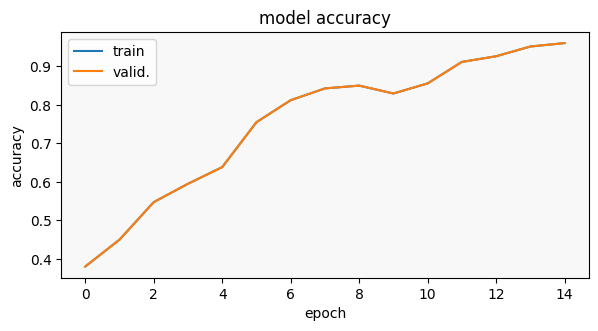

In [187]:
display_training_curves(history.history['loss'], history.history['loss'], 'loss', 211)
display_training_curves(history.history['categorical_accuracy'], history.history['categorical_accuracy'], 'accuracy', 212)